<h3> Подключаем библиотеки

In [141]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

<h3> Очищаем данные

In [142]:
def clean_data(train_path: str, additional_dir: str):

    # Загрузка данных
    train = pd.read_excel(train_path, parse_dates=['dt'], engine='openpyxl')
    additional_files = list(Path(additional_dir).glob('*.xlsx'))
    
    # Загрузка и объединение всех данных
    all_dfs = [train]
    for file in additional_files:
        df = pd.read_excel(file, engine='openpyxl')
        df['dt'] = pd.to_datetime(df['dt'])
        all_dfs.append(df)
    
    #Объединение данных в один список
    combined = pd.concat(all_dfs, ignore_index=True)
    
    # Определяем начало недели (понедельник)
    combined['week_start'] = combined['dt'] - pd.to_timedelta(combined['dt'].dt.dayofweek, unit='D')
    
    # Агрегация по медиане для всех числовых колонок
    numeric_cols = combined.select_dtypes(include=['number']).columns.tolist()
    weekly_df = combined.groupby('week_start')[numeric_cols].median().reset_index()
    
    # Переименовываем колонку week_start в dt
    df = weekly_df.rename(columns={'week_start': 'dt'})

    df = df.replace('', np.nan)  # Заменяем пустые строки на NaN
    df = df.replace(0, np.nan)  # Заменяем 0 на NaN
    df = df.replace('0', np.nan) # Заменяем строковое "0" на NaN

    # Заполняем пропуски, который образовались из-за разрыва месячных данных на недели
    for col in df.columns:
        first_valid_index = df[col].first_valid_index()
        if first_valid_index is not None:
            non_nan_indices = df[col].dropna().index
            for index in non_nan_indices:
                fill_indices = range(index + 1, min(index + 1 + 3, len(df)))
                for i in fill_indices:
                    if pd.isna(df.loc[i, col]):
                        df.loc[i, col] = df.loc[index, col]
    
    threshold = 0.70 # 70% пропусков допустимо, больше - удаляем колонку
    for col in df.columns:
        if df[col].isnull().sum() / len(df) > threshold:
            df.drop(col, axis=1, inplace=True)  # Удаляем слишком пустой столбец в цикле

    test_df = df[df['dt'] > pd.to_datetime('2022-08-29')]
    test_df = test_df[test_df['dt'] <= pd.to_datetime('2023-03-13')]
    df = df[df['dt'] <= pd.to_datetime('2022-08-29')]

    # Заполняем пропуски методом соседних значений
    df = df.ffill().bfill()  # Применяем ffill, а затем bfill
    test_df = test_df.ffill().bfill()  # Применяем ffill, а затем bfill
    test_df['price'] = np.nan

    # Возвращаем готовый датасет
    return df, test_df


def clean_feature_names(df):
    # Транслитерация русских букв и замена спецсимволов
    translation = {
        'а': 'a', 'б': 'b', 'в': 'v', 'г': 'g', 'д': 'd', 'е': 'e', 
        'ё': 'yo', 'ж': 'zh', 'з': 'z', 'и': 'i', 'й': 'y', 'к': 'k', 
        'л': 'l', 'м': 'm', 'н': 'n', 'о': 'o', 'п': 'p', 'р': 'r', 
        'с': 's', 'т': 't', 'у': 'u', 'ф': 'f', 'х': 'h', 'ц': 'ts', 
        'ч': 'ch', 'ш': 'sh', 'щ': 'sch', 'ъ': '', 'ы': 'y', 'ь': '', 
        'э': 'e', 'ю': 'yu', 'я': 'ya'
    }
    
    cleaned_columns = []
    for col in df.columns:
        # Транслитерация
        col_str = str(col).lower()
        col_clean = ''.join([translation.get(c, c) for c in col_str])
        
        # Удаление оставшихся запрещенных символов
        col_clean = ''.join([c if c.isalnum() or c == '_' else '_' for c in col_clean])
        
        cleaned_columns.append(col_clean)
    
    df.columns = cleaned_columns
    return df

df, test_df = clean_data(train_path='train.xlsx', additional_dir='D:\Visual Studio Code\Intensive_Armatyra\data')
df = clean_feature_names(df)
test_df = clean_feature_names(test_df)
print(df.head()) # Выводим готовый датасет
df.to_excel('merged_data.xlsx', index=False, engine='openpyxl') # Сохраняем готовый датасет
test_df.to_excel('test_df.xlsx', index=False, engine='openpyxl') # Сохраняем готовый датасет

<>:85: SyntaxWarning: invalid escape sequence '\V'
<>:85: SyntaxWarning: invalid escape sequence '\V'
C:\Users\slava\AppData\Local\Temp\ipykernel_4812\596222300.py:85: SyntaxWarning: invalid escape sequence '\V'
  df, test_df = clean_data(train_path='train.xlsx', additional_dir='D:\Visual Studio Code\Intensive_Armatyra\data')


          dt    price  indeks_stoimosti_gruzoperevozok  klyuchevaya_stavka  \
0 2015-01-05  32900.0                           1000.0                7.75   
1 2015-01-12  32500.0                           1000.0                7.75   
2 2015-01-19  32000.0                           1000.0                7.75   
3 2015-01-26  30700.0                           1000.0                7.75   
4 2015-02-02  30300.0                           1000.0                7.75   

   kurs_dollara  proizvodstvo_armatury_sortovoy_prokat_armatura  \
0      56.93455                                           527.0   
1      56.93455                                           527.0   
2      56.93455                                           527.0   
3      56.93455                                           527.0   
4      56.93455                                           527.0   

   proizvodstvo_armatury_sortovoy_prokat_katanka  \
0                                          208.0   
1                       

In [143]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns
boolean_columns = df.select_dtypes(include=['bool']).columns

print("")
print(f"Числовые колонки в готовом датасете: {len(numeric_columns)}")
print(f"Категориальные колонки в готовом датасете: {len(categorical_columns)}")
print(f"Булевые колонки в готовом датасете: {len(boolean_columns)}")


Числовые колонки в готовом датасете: 120
Категориальные колонки в готовом датасете: 0
Булевые колонки в готовом датасете: 0


<Axes: >

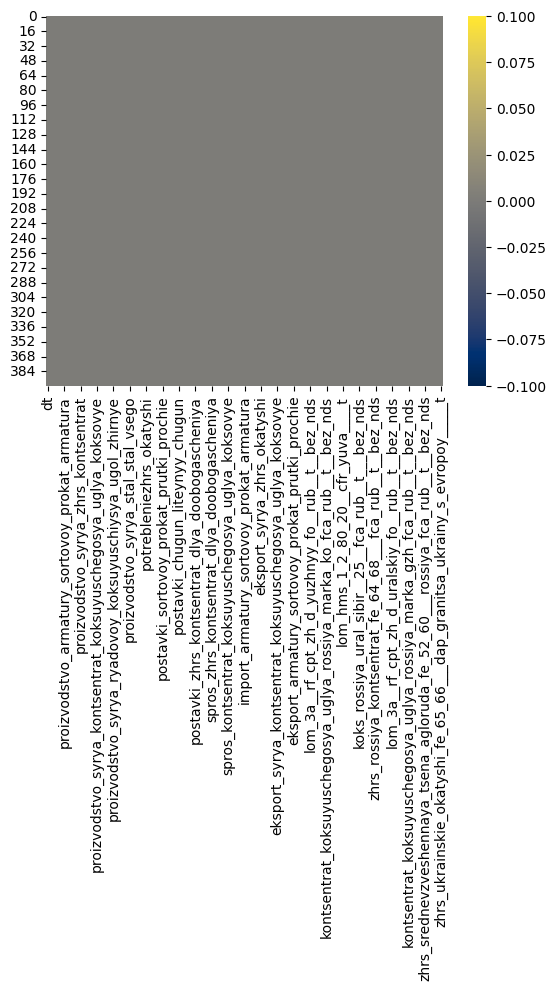

In [144]:
sns.heatmap(df.isnull(), cmap='cividis')

Период трейна: 2015-01-05 00:00:00 - 2022-08-29 00:00:00
Период теста: 2022-09-05 00:00:00 - 2023-03-13 00:00:00


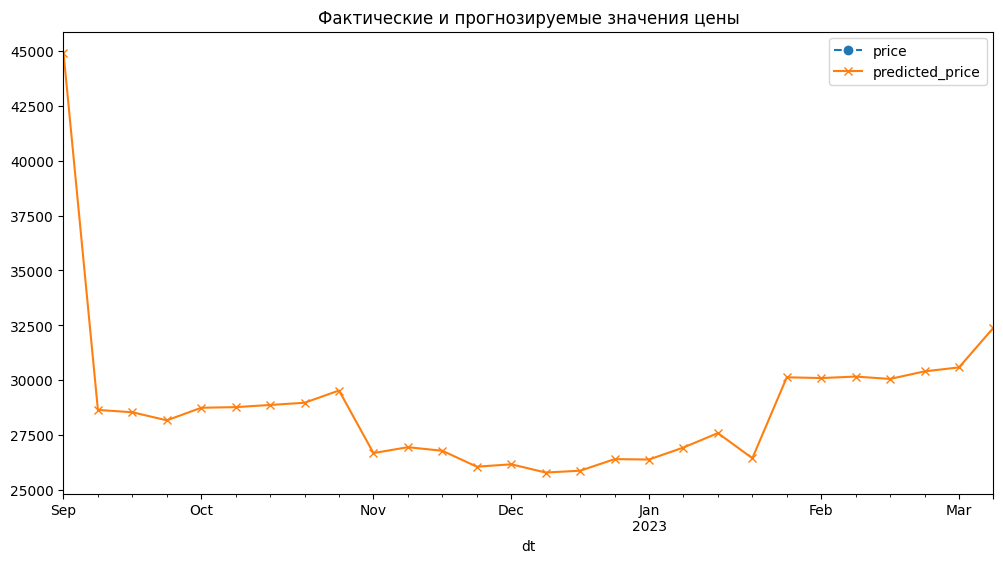

In [147]:
# Загрузка данных
train_data = pd.read_excel('merged_data.xlsx', parse_dates=['dt'])
test_data = pd.read_excel('test_df.xlsx', parse_dates=['dt'])

# Сортировка по дате
train_data = train_data.sort_values('dt')
test_data = test_data.sort_values('dt')

# Проверка временной структуры
print("Период трейна:", train_data['dt'].min(), "-", train_data['dt'].max())
print("Период теста:", test_data['dt'].min(), "-", test_data['dt'].max())

# Создание временных признаков (день недели не нужен - все понедельники)
for df in [train_data, test_data]:
    df['year'] = df['dt'].dt.year
    df['month'] = df['dt'].dt.month
    df['weekofyear'] = df['dt'].dt.isocalendar().week
    
# Лаги и скользящие средние
for df in [train_data, test_data]:
    # Лаги цены
    for lag in [1, 4, 12]:  # 1 неделя, 1 месяц, 3 месяца
        df[f'price_lag_{lag}'] = df['price'].shift(lag)
    
    # Скользящее среднее
    df['price_rolling_4'] = df['price'].shift(1).rolling(4).mean()

# Заполнение пропусков в тестовых данных из трейна
last_train_values = train_data.iloc[-12:][['price']].values.flatten()
for i, lag in enumerate([1, 4, 12]):
    test_data.loc[test_data.index[0], f'price_lag_{lag}'] = last_train_values[-lag]

train_data.dropna(inplace=True)

# Отбор фичей
features = [col for col in train_data.columns if col not in ['dt', 'price', 'dayofweek']]
X_train = train_data[features]
y_train = train_data['price']
X_test = test_data[features]

# Обучение модели с учетом недельной сезонности
model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=2000,
    learning_rate=0.02,
    num_leaves=31,
    max_depth=7,
    min_data_in_leaf=20,
    random_state=42,
    reg_alpha=0.1,
    reg_lambda=0.1
)

model.fit(X_train, y_train)

# Прогнозирование
test_data['predicted_price'] = model.predict(X_test)

# Оценка (если true значения есть)
if 'price' in test_data.columns:
    y_test = test_data['price']
    # print(f'MAE: {mean_absolute_error(y_test, test_data["predicted_price"])}')
    # print(f'RMSE: {np.sqrt(mean_squared_error(y_test, test_data["predicted_price"]))}')
    # print(f'R²: {r2_score(y_test, test_data["predicted_price"]):.2f}')

# Визуализация прогноза
test_data[['dt', 'price', 'predicted_price']].set_index('dt').plot(
    title='Фактические и прогнозируемые значения цены',
    figsize=(12, 6),
    style=['o--', 'x-']
)

# Экспорт прогнозов
test_data['price'] = test_data['predicted_price']
test_data.to_excel('price_predictions.xlsx', index=False)